# Cue Reward Association 

In this simple meta-learning task, one of four randomly generated 20-bit input cues is arbitrarily chosen as a *target cue*. The agent is repeatedly shown two random cues in succession, and then a *response cue* during which the agent must respond with a 1 if the target was part of the pair, or 0 otherwise. 


**Google Drive Set-up:**

Note: This is not necessary if running locally.

In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# project folder, e.g. 'project submissions/A09_A10_A54'
# $$ for us - 'DSc Term Project/'
FOLDERNAME = 'DSc Term Project/Task 1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# test - this notebooks name should show up:
# is oserror - restart runtime
%cd /content/drive/My\ Drive/$FOLDERNAME
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1khPuOHY9jnXOARox2UYYUJ3TRirri2cS/DSc Term Project/Task 1
'Cue Reward Association.ipynb'   RM.ipynb          SM_rudraksh.ipynb
 NM.ipynb                        RM_theirs.ipynb   SM_theirs.ipynb
 NP.ipynb                        saved/            utils/
'Plot Test.ipynb'                SM.ipynb


**Import Statements:**


In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.optim import lr_scheduler

import numpy as np
import time
import pickle
import random
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots


np.set_printoptions(precision=4)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

**GPU Set-up:**

You have an option to use GPU by setting the flag to `True` below.

The global variables `dtype` and `device` will control the data types throughout this notebook. 

You need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [4]:
# flag
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.float32
else:
    device = torch.device('cpu')
    dtype = torch.float32

print('Using Device:', device)

Using Device: cuda


### Training

The cells in this section define utility functions required by the `train()` function, which is given in the last cell.

**Creating Networks:**

We will use 4 different types of recurrent neural networks (RNNs) to show the effect of modulation and plasticity on the accumulated reward in this task. These are defined in `utils/networks.py`. In our experiments we will analyse the following RNNs:
1. Non-Plastic, Non-Modulated  `NP`
2. Plastic, Non-Modulated `NM`
3. Plastic, Simple Modulation `SM`
4. Plastic, Retro Modulation `RM`

We define a function `get_network()` that takes a dictionary `params` (defined later) holding the parameters required for the networks as well as a variable `type` dictating which of the RNNs is to be returned. It also migrates the model to the GPU, if available.


In [0]:
from utils.networks import *

def get_network():
    # determine which RNN to return
    net_type = params['net_type']
    if net_type == 'NP':
        RNN = NonPlastic_NonModulated_RNN(params)
    elif net_type == 'NM':
        RNN = Plastic_NonModulated_RNN(params)
    elif net_type == 'SM':
        RNN = Plastic_SimpleModulated_RNN(params)
    else:
        RNN = Plastic_RetroactiveModulated_RNN(params)

    # move to GPU and return, if possible
    RNN.to(device=device, dtype=dtype)
    return RNN
  

**Visualizations:**

We define a function `start_graphics()` to add visualizations so the activities performed in this task are better understood. We have used `graphics.py`, a Python library developed by *Zelle*.

Note: It is not possible to run these visualisations on Google Colab. Please download and run this notebook locally if you wish to do so, and uncomment the import statement in the first line.

In [0]:
#from graphics import *

def start_graphics():
    if params['visualise']:
        # set title and background
        win = GraphWin("Cue Visualization", 750, 700)
        win.setBackground('light blue')

        # lists to hold the cues
        GraphicsCues=[]
        MainCues=[]

        # create the cues and store in GraphicsCues[]
        for j in range(NUM_CUE_BITS +1):
            aRectangle = Rectangle(Point(50+j*25,50), Point(75+j*25,75))
            aRectangle.setFill('black')
            aRectangle.setOutline('yellow')
            aRectangle.draw(win)
            GraphicsCues.append(aRectangle)

        # text set up
        message=Text(Point(300,15),'Present Cue')
        message.setTextColor('red')
        message.setStyle('bold')
        message.setSize(15)
        message.draw(win)
        m=Text(Point(650,250),'Network Response')
        m.draw(win)

        # 
        Cir = Circle(Point(650,350),50)
        Cir.setFill('yellow')
        Cir.draw(win)
        for j in range(5):
            Arr=[]
            for k in range(NUM_CUE_BITS+1):
                aRectangle = Rectangle(Point(100+j*100,100+k*25), Point(100+j*100+25,100+k*25+25))
                aRectangle.setFill('black')
                aRectangle.setOutline('yellow')
                aRectangle.draw(win)
                Arr.append(aRectangle)
            MainCues.append(Arr)
            if(j!=4):
                msg=Text(Point(100-5+j*100,650),'  Cue no '+str(j+1))
            else:
                msg=Text(Point(100-5+j*100,650),'Target Cue')
            msg.setStyle('bold')
            msg.setTextColor('green')
            msg.draw(win)

        # return
        return GraphicsCues, MainCues, win , Cir
    else:
        return None, None, None, None

**Generating Cues:**

We define a function `generate_cues()` that randomly generates the `NUM_CUE_BITS`-bit cues required for the experiments, making sure none are the same.

In [0]:
def generate_cues(Cues):
    # Running through each batch 
    Cues = []
    for nb in range(params['batch_size']):
        Cues.append([])
        for ncue in range(NUM_CUES):
            assert len(Cues[nb]) == ncue
            foundsame = 1
            cpt = 0
            while foundsame > 0 :
                cpt += 1
                if cpt > 10000:
                    # This should only occur with very weird parameters, e.g. cs=2, ni>4
                    raise ValueError("Could not generate a full list of different cues")
                foundsame = 0
                candidate = np.random.randint(2, size=NUM_CUE_BITS) * 2 - 1
                for backtrace in range(ncue):
                    if np.array_equal(Cues[nb][backtrace], candidate):
                        foundsame = 1

            Cues[nb].append(candidate)
            
    return Cues

**Calculating Rewards:**

Here we define a function `calculate_rewards()` that takes in the following parameters and updates the `rewards` list accordingly.

1.    The list `reward` stores the reward for each batch.
2.    The array `numactionschosen` is a list which has the network's response for each batch. (Either 0 or 1).
3.  `step_in_trial` holds the step number of a batch in the trial being executed. Ex : If it is 2 for a specific batch that means presently the 2nd step of the trial is being run.
4. `Present_Trial_Has_Target` is a list which stores '0' if the target is present in a particular trial or '1' if the target isn't present.
5. `trial_length` is a list which stores the length of each trial since this is randomly determined.
6. `Current_Cue_In_Trial` is a list to check if the current cue is one of the actual cues.



In [0]:
# note: if batch size is 16, a batch contains 16 'agents'
def calculate_rewards(numactionschosen , reward ,step_in_trial , Present_Trial_Has_Target, triallength, Current_Cue_In_Trial ):
    for nb in range(params['batch_size']):

          if numactionschosen[nb] == 1:
              # Small penalty for any non-rest action taken
              reward[nb]  -= params['penalty']


          step_in_trial[nb] += 1
          if step_in_trial[nb] == triallength[nb] - 1:

              # This was the next-to-last step of the trial (and we showed the response signal, unless it was the first few steps in episode).
              assert(Current_Cue_In_Trial[nb][step_in_trial[nb] - 1] == NUM_CUES or numstep < 2)

              # Based on network response, we give a negative or positive reward

              if Present_Trial_Has_Target[nb] and numactionschosen[nb] == 1:
                  reward[nb] += params['reward']
              elif (not Present_Trial_Has_Target[nb]) and numactionschosen[nb] == 0:
                  reward[nb] += params['reward']
              else:
                  reward[nb] -= params['reward']

          if step_in_trial[nb] == triallength[nb]:
              # This was the last step of the trial (and we showed no input)
              assert(Current_Cue_In_Trial[nb][step_in_trial[nb] - 1] == -1 or numstep < 2)
              #nbtrials[nb] += 1

              if Present_Trial_Has_Target[nb]:
                  pass
                  #nbrewardabletrials += 1

              # Trial is completed
              step_in_trial[nb] = 0

    return reward, step_in_trial

**Carrying out a Step of a Trial:**

We define a function `carry_out_trial()` that takes 10 different inputs and simulates a step in a trial. In the beginning of each trial, the cues to be shown are randomly decided beforehand. This happens as follows :


*   Each trial consists of several steps
*   In each step of trial, a cue is input to the network
*   This cue is either a blank cue or a GO Cue where the network has to respond or one of the 4 cues chosen at the beginning of an episode
*   Each trial has 2 of the 4 chosen cues, a random number of blank cues and a GO cue at the end.





In [0]:
def carry_out_trial(step_in_trial, thistrialhascorrectcue, triallength, inputs, Current_Cue_In_Trial, Cues, correctcue,numactionschosen, numstep,reward):
    NBINPUTBITS = NUM_CUE_BITS+1
  
    for nb in range(params['batch_size']):
        if step_in_trial[nb] == 0:
            thistrialhascorrectcue[nb] = 0
            triallength[nb] = NUM_CUES // 2  + 3 + np.random.randint(NUM_CUES)  # 3 fixed-cue time steps (1st, last and next-to-last) + some random nb of no-cue time steps

            # In any trial, we only show half the cues (randomly chosen), once each:
            mycues = [x for x in range(NUM_CUES)]
            random.shuffle(mycues); mycues = mycues[:len(mycues) // 2]

            # The rest is filled with no-input time steps (i.e. cue = -1), but also with the 3 fixed-cue steps (1st, last, next-to-last)
            for nc in range(triallength[nb] - 3  - len(mycues)):
                mycues.append(-1)

            random.shuffle(mycues)
            mycues.insert(0, -1); mycues.append(NUM_CUES); mycues.append(-1)  # The first and last time step have no input (cue -1), the next-to-last has the response cue.
            assert(len(mycues) == triallength[nb])
            Current_Cue_In_Trial[nb] = mycues


        inputs[nb, :NBINPUTBITS] = 0
        if Current_Cue_In_Trial[nb][step_in_trial[nb]] > -1 and Current_Cue_In_Trial[nb][step_in_trial[nb]] < NUM_CUES:
            #inputs[0, cues[step_in_trial]] = 1.0
            inputs[nb, :NBINPUTBITS-1] = Cues[nb][Current_Cue_In_Trial[nb][step_in_trial[nb]]][:]
            if Current_Cue_In_Trial[nb][step_in_trial[nb]] == correctcue[nb]:
                Present_Trial_Has_Target[nb] = 1
        if Current_Cue_In_Trial[nb][step_in_trial[nb]] == NUM_CUES:
            inputs[nb, NBINPUTBITS-1] = 1  # "Go" cue


        inputs[nb, NBINPUTBITS + 0] = 1.0                                           # Bias neuron, probably not necessary
        inputs[nb, NBINPUTBITS + 1] = numstep / params['episode_length']            # 
        inputs[nb, NBINPUTBITS + 2] = 1.0 * reward[nb]                              # Reward from previous time step
        if numstep > 0:
            inputs[nb, NBINPUTBITS + ADDITIONAL_INPUTS + numactionschosen[nb]] = 1  # Previously chosen action

            

**Other Utility Functions:**

Here we define some additional helper functions that help us keep our code oragnised in this notebook, and reduce the LOC in the `train()` function


In [0]:
# returns a dictionary of blank lists corresponding to the statistics
# over all episodes we wish to track in our experiments
def get_blank_statistics_dict():
    all_stats = {
        'losses' : [],
        'grad_norms' : [],
        'losses_objective' : [],
        'total_rewards' : [],
        'losses_v' : [],
        'mean_reward' : [],
        'total_rewards_batchwise' : []
    }
    return all_stats


# called at the start of each episode to individually reset the values of 
# hebb, prev, E, and plastic_weights (check architechture for more details)
# note: none of these require grads since we manually update them
def initial_zero_BH(): # used to reset prev hidden state (BxH)
    return Variable(torch.zeros(params['batch_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype)

def initial_zero_BHH(): # used to reset E (eligibility trace), plastic_weights, and hebb
    return Variable(torch.zeros(params['batch_size'], params['hidden_size'], params['hidden_size']), 
                    requires_grad=False).to(device, dtype) # (BxHxH)



**Training Function:**

This is the main function we've used to train the network and analyze it's response over all episodes and for all batches. 


In [0]:
def train():
    # print current parameters as a check - global variables
    print(params)

    # set random seeds for training, so that results are comparable
    np.random.seed(params['rng_seed'])
    random.seed(params['rng_seed'])
    torch.manual_seed(params['rng_seed'])

    # create the network required determined by params['net_type']
    net = get_network()

    # initialise optimiser - we use Adam with L2 reg
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=params['learning_rate'], 
                                 weight_decay=params['lambd'])
    
    # create dictionary to keep track of stats over all episodes
    lossbetweensaves = 0
    nowtime = time.time()

    # For graphics
    GraphicsCues, MainCues, win, Cir = start_graphics()


    # if we're continuing training we don't need to start over
    if params['saved_already'] == False:
        # create dictionary to keep track of stats over all episodes
        all_stats = get_blank_statistics_dict()
        epoch = 0
    else:
        # otherwise extract from saved state
        checkpoint_path = 'saved/Checkpoint' + params['net_type'] + '.pt'
        checkpoint = torch.load(checkpoint_path)
        print(net.load_state_dict(checkpoint['state_dict']))
        print(optimizer.load_state_dict(checkpoint['optimizer']))
        epoch = checkpoint['iters'] + 1
        all_stats = checkpoint['stats_dict'] 
        print(f"Loaded from '{checkpoint_path}' at episode {epoch}")


    # loop over every episode (or every remaining episode)
    for numiter in tqdm(range(epoch, params['num_episodes'])): 
        # Generate the cues. Make sure they're all different 
        Cues = generate_cues(Cues)

        # we zero out these values before each episode according to their lifetime
        # cache holds the extra inputs and outputs needed according to different network types 
        # initially cache is a list, then we convert it to a tuple
        prev = initial_zero_BH()
        cache = [prev]
        if params['net_type'] != 'NP':  # hebb is only for plastic
            hebb = initial_zero_BHH()
            cache.append(hebb)
        if params['net_type'] == 'RM':  # these are only for retroactive modulated
            E_t = initial_zero_BHH()              
            plastic_weights = initial_zero_BHH()
            cache.append(E_t)
            cache.append(plastic_weights)
        cache = tuple(cache)


        # Make all gradients zero since pytorch accumulates them
        optimizer.zero_grad()
        
  
        # additional variables
        loss = 0                                    # loss is accumulated over the episode
        lossv = 0                                   # needed for A2C
        numactionchosen = 0                         # 0 -> not present, 1 -> present
        reward = np.zeros(params['batch_size'])     # reward for each trial  
        sumreward = np.zeros(params['batch_size'])  # reawrd acoress all trials
        rewards = []                                # reward history
        vs = []                                     # vs for A2C algorithm
        logprobs = []                               # for A2C algortihm

        Current_Cue_In_Trial=[]                     # 2D list to store if correct cue was in the trial
        for nb in range(params['batch_size']):
            Current_Cue_In_Trial.append([])

        numactionschosen = np.zeros(params['batch_size'], dtype='int32')    # actions for each batch
        nbtrials = np.zeros(params['batch_size'])                           # Number of trials for each batch
        nbrewardabletrials = np.zeros(params['batch_size'])                 # used during rewards calculation
        Present_Trial_Has_Target = np.zeros(params['batch_size'])           # Used to calculate rewards
        triallength = np.zeros(params['batch_size'], dtype='int32')         # Keeps track of length of each trial
        correctcue = np.random.randint(NUM_CUES, size=params['batch_size']) # select a correct cue for this episode
        step_in_trial = np.zeros(params['batch_size'], dtype='int32')       # current step in each trial

        # loop over the trials in each episode
        for numstep in range(params['episode_length']): 
            
            inputs = np.zeros((params['batch_size'], params['input_size']), dtype='float32')
            NBINPUTBITS = NUM_CUE_BITS+1
            
            # Perform a step in each batch 
            carry_out_trial(step_in_trial, Present_Trial_Has_Target, triallength, inputs, Current_Cue_In_Trial, Cues,correctcue, numactionschosen, numstep, reward)
            
            # create a tensor from the inputs and pass it into the network 
            inputsC = torch.from_numpy(inputs).to(device, dtype)
            inputs_tensor = Variable(inputsC, requires_grad=False)
            y, v, cache = net(inputs_tensor, cache)                        # y  should output raw scores, not probas

            # we apply softmax to get probabilities
            y = torch.softmax(y, dim=1)             

            # create distribution according to y and randomly choose an action accordingly
            distrib = torch.distributions.Categorical(y)
            actionschosen = distrib.sample()
            logprobs.append(distrib.log_prob(actionschosen))     # store log of proba for A2C

            numactionschosen = actionschosen.data.cpu().numpy()       # convert to CPU numpy from pytorch
            reward = np.zeros(params['batch_size'], dtype='float32')  

            # Auxiallary function to calculate rewards for each agent 
            reward, step_in_trial = calculate_rewards(numactionschosen, reward, step_in_trial , Present_Trial_Has_Target, triallength ,Current_Cue_In_Trial)
      
            # update globals
            rewards.append(reward)
            vs.append(v) 
            sumreward += reward

            # This is an "entropy penalty", implemented by the sum-of-squares of the probabilities 
            # The result is to encourage diversity in chosen actions.
            # somewhat similar to regularization 
            loss += ( params['entropy_reward_coeff'] * y.pow(2).sum() / params['batch_size'] )


        # Episode is done, now do the actual computations of rewards and losses for the A2C algorithm
        R = torch.zeros(params['batch_size']).to(device)
        gammaR = params['reward_discount_factor']    #Discounting factor for rewards
        for numstepb in reversed(range(params['episode_length'])) :         # Every step in an episode has a reward
            R = gammaR * R + torch.from_numpy(rewards[numstepb]).to(device)
            ctrR = R - vs[numstepb][0]
            lossv += ctrR.pow(2).sum() / params['batch_size']
            loss -= (logprobs[numstepb] * ctrR.detach()).sum() / params['batch_size']


        loss += params['lossv_coeff'] * lossv      # Coefficient for value prediction loss
        loss /= params['episode_length'] 
        

        # perform backprop and gradient clipping
        loss.backward()
        all_stats['grad_norms'].append(torch.nn.utils.clip_grad_norm_(net.parameters(), params['gradient_clip']))
        if numiter > 100:  # Burn-in period for meanrewards
            optimizer.step()

        # update stats
        lossnum = float(loss)
        lossbetweensaves += lossnum
        all_stats['losses_objective'].append(lossnum)
        all_stats['total_rewards'].append(sumreward.mean())
        all_stats['total_rewards_batchwise'].append(sumreward)

        # Printitng statistics after a certain number of episodes
        if (numiter+1) % params['print_every'] == 0:
            print(f'\nThis is episode {numiter}:')
            print("lossv: ", float(lossv))
            print ("Total reward for this episode (all):", sumreward)
          
            print(numiter, "==============")
            print("Mean loss: ", lossbetweensaves / params['print_every'])
            lossbetweensaves = 0
            print("Mean reward (across batch and last", params['print_every'], "eps.): ", np.sum( all_stats['total_rewards'][-params['print_every']:])/ params['print_every'])
            print("Mean reward (across batch): ", sumreward.mean())
            previoustime = nowtime
            nowtime = time.time()
            print("Time spent on last", params['print_every'], "iters: ", nowtime - previoustime)

        # save checkpoints according to 'save_every'
        if (numiter+1) % params['save_every'] ==0 :
            state = {
                'iters': numiter,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'stats_dict': all_stats
            }
         savepath='saved/Checkpoint'+params['net_type']+'.pt'
         torch.save(state,savepath)
         print(f"Saved to '{savepath}' at episode {numiter}")

    # return final state    
    return {
          'iters': params['num_episodes'],
          'state_dict': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'stats_dict': all_stats
          }

### Experiments:

**Initialising Default Parameters:**

Here we define a global dictionary `params` containing all the parameters required during training and those required to create the recurrent neural networks. These values are changed as required before training for different experiments, by directly updating the values required. Therefore, most of the values defined in the following cell are NOT updated here itself. 

Thus, we also keep a copy of these default parameters in `default_params`, and define a function `reset_parameters()` that will reset all parameters. This is called before the start of each experiment, and it helps us to keep our experiments controlled easily.

We also create a function `alter_params_for_save()` to remove functions from the dictionary so it can be pickled if required.

We initialise some other constants, for example number of additional inputs.

In [0]:
# constants
NUM_CUE_BITS = 20
NUM_CUES = 4
ADDITIONAL_INPUTS = 4 # 1 input for the previous reward, 1 input for numstep, 1 unused,  1 "Bias" input
NUM_ACTIONS = 2   # YES OR NO
TOTAL_NUM_INPUTS =  NUM_CUE_BITS + 1 + ADDITIONAL_INPUTS + NUM_ACTIONS

# these are kept constant while experimenting!
params = {
    # hyperparameters to be found out and fixed for optimum training (experiment 2)
    'learning_rate' : 1e-4 ,
    'hidden_size' : 200 ,
    'lambd' : 0 ,      # for l2 norm reg 

    # parameters for other experiments 
    'net_type' : 'NP' ,
    'fully_modulated' : True ,
    'neuromod_neurons' : 1 ,
    
    # other parameters
    'episode_length' : 120 , 
    'num_episodes' : 60 ,
    'batch_size' : 10 ,
    'print_every' : 10000 ,  
    'rng_seed' : 0 ,

    'penalty'  :  0  , # Wall hitting penalty - not needed here
    'reward' : 1 ,
    'gradient_clip' : 7.0 ,  
    'activation' : torch.tanh ,
    
    'eta_init_value' : 0.1 ,
    'neuromod_activation' : torch.tanh ,
    'entropy_reward_coeff' : 0.1 ,  
    'lossv_coeff': .1 ,        # Coefficient for value prediction loss
    'reward_discount_factor' : 0.9 ,

    'input_size' : TOTAL_NUM_INPUTS ,
    'output_size' : NUM_ACTIONS ,

    'verbose' : False ,
    'visualise': False , 
    
}


default_params = params
def reset_parameters():
    global params
    params = default_params

# make sure to call reset after this
def alter_params_for_save():
    params['activation'] = None
    params['neuromod_activation'] = None

**Experiment: Different Types of Networks**

Here we see the effect of the type of recurrent neural network on the reward accumulated and the total loss.

Only the parameter `net_type` is changed here.

The appropriate blocks are commenrted and uncommneted as required.


In [0]:
reset_parameters()

#### Non-Plastic
# params['net_type'] = 'NP'
# to_save = train()

#### Plastic, Non-Modulated
# params['net_type'] = 'NM'
# to_save = train()

#### Plastic, Simple Modulation
# params['net_type'] = 'SM'
# to_save = train()

#### Plastic, Retroactive Modulation
params['net_type'] = 'RM'
to_save = train()

{'learning_rate': 0.0001, 'hidden_size': 200, 'lambd': 0, 'net_type': 'NM', 'fully_modulated': True, 'neuromod_neurons': 1, 'episode_length': 120, 'num_episodes': 60, 'batch_size': 10, 'print_every': 10000, 'rng_seed': 0, 'penalty': 0, 'reward': 1, 'gradient_clip': 2.0, 'activation': <built-in method tanh of type object at 0x7f18ceeba300>, 'parameter_init_function': <function xavier_normal_ at 0x7f18870779d8>, 'eta_init_value': 0.1, 'neuromod_activation': <built-in method tanh of type object at 0x7f18ceeba300>, 'inversion_factor': 0, 'entropy_reward_coeff': 0.1, 'lossv_coeff': 0.1, 'reward_discount_factor': 0.9, 'input_size': 27, 'output_size': 2, 'verbose': False, 'visualise': False}


**Saving:**

Now we save the final model parameters and results in the correct file!

In [0]:
savepath = 'saved/Final' + params['net_type'] + '.pt'
torch.save(to_save, savepath)
print("Saved!")

**Plotting Results**

Here we plot the total rewards accumulated according to network type, and save the figure using the `matplotlib.pyplot` library.

In the figures, the lighter shade is a plot of all the total rewards while the darker is the mean of the total rewards over `average_over` episodes.

Note: During our experiments, the NP and SM results were saved in a different manner than the others due to different times of execution, i.e. before we added the checkpointing code. 

(You must run on a GPU to plot our results)

[Errno 2] No such file or directory: 'saved'
/content/drive/.shortcut-targets-by-id/1khPuOHY9jnXOARox2UYYUJ3TRirri2cS/DSc Term Project/Task 1/saved
Plotted NP
Plotted NM
Plotted SM
Plotted RM


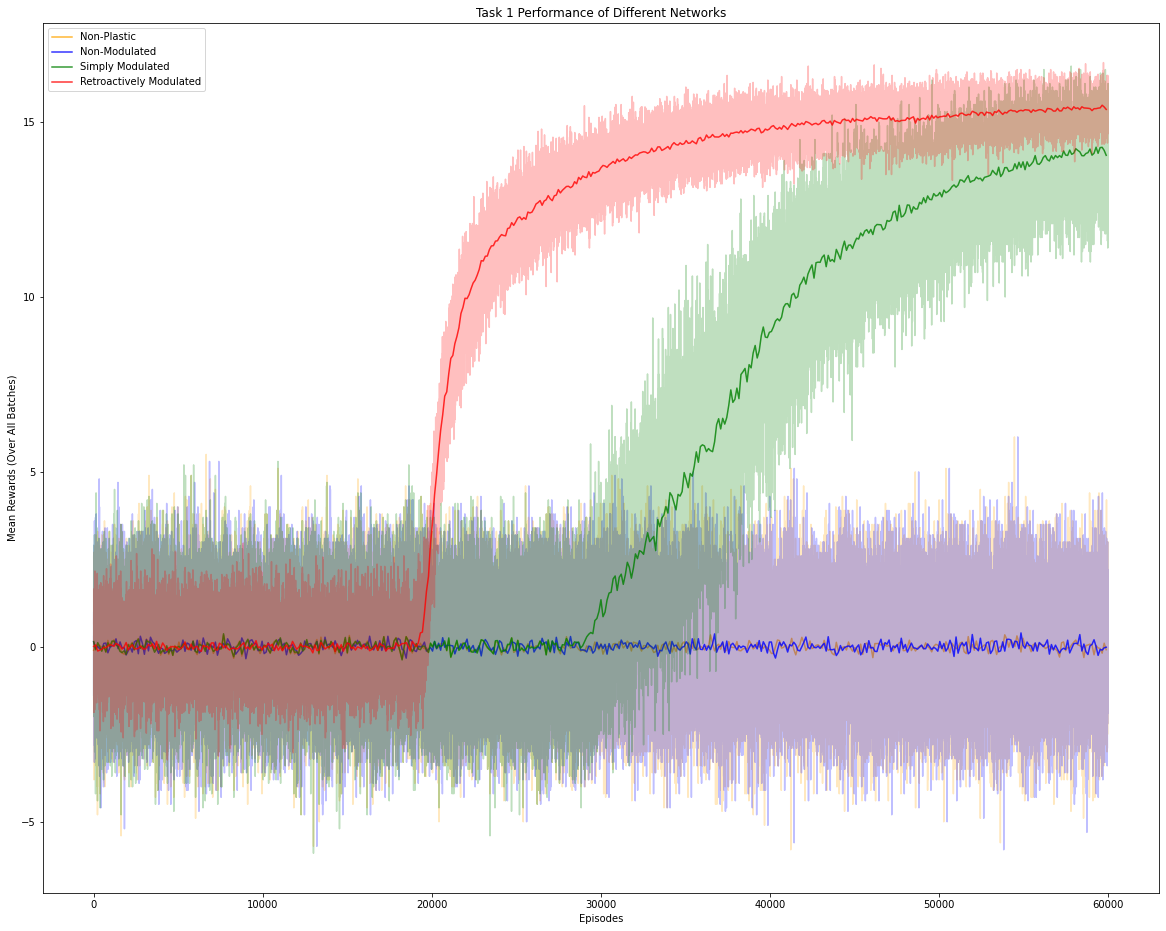

/content/drive/.shortcut-targets-by-id/1khPuOHY9jnXOARox2UYYUJ3TRirri2cS/DSc Term Project/Task 1


In [11]:
%cd saved
net_types = ['NP', 'NM', 'SM', 'RM']
labels = ['Non-Plastic', 'Non-Modulated', 'Simply Modulated', 'Retroactively Modulated']
colors = ['orange', 'blue', 'green', 'red']
average_over = 120

for net_type, label, color in zip(net_types, labels, colors):

    if net_type == 'NP' or net_type == 'SM':
        name = net_type + '_stats.pkl'
        with open(name, 'rb') as handle:
            all_stats = pickle.load(handle)
    else:
        all_stats = torch.load('Final' + net_type + '.pt')['stats_dict']

    
    y = all_stats['total_rewards']
    x = range(len(y))
    plt.plot(x,y, alpha = 0.25, color = color)

    y = np.asarray(y)
    y_avg = []
    for i in range(0,len(y),average_over):
        avg = np.mean(y[i : i+average_over])
        y_avg.append(avg)
    x = np.asarray(x)[::average_over]
    plt.plot(x,y_avg, alpha = 0.8, color = color, label=label)
    print("Plotted", net_type)
    
plt.title("Task 1 Performance of Different Networks")
plt.xlabel("Episodes")
plt.ylabel("Mean Rewards (Over All Batches)")
plt.legend(loc='best')
plt.savefig('Task 1 Performance')
plt.show()

%cd /content/drive/My\ Drive/$FOLDERNAME


### Results

We can see that the best performance of around 15 mean reward is achieved by the retroactively modulated network. Good performance of about slightly less than 15 mean reward is achieved by the simply modulated network, although it requires more training to reach the same level. The non-modulated networks do not learn the task at all and give a mean reward of 0 throughout.